# Task 1

In [1]:
import qiskit
import numpy as np

from numpy import pi
from qiskit import BasicAer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

%matplotlib inline

In [2]:
backend = BasicAer.get_backend('qasm_simulator')

## Part 1
#### Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

In the function below, r_x and r_z are parameters to the circuit. Varying r_x and r_z changes the rotation on the x-axis and z-axis respectively which allows any point in the Bloch sphere to be reached.

In [3]:
def generate_qubit_state(rx_radians: float=None, rz_radians: float=None) -> Statevector:
    """Generates a general qubit state using Rx and Rz gates. Generates a random qubit state if no arguments are provided

    Args:
        r_x: Rotation in X-axis in radians. Defaults to random value
        r_z: Rotation in Z-axis in radians. Defaults to random value
    """
    if not rx_radians:
        rx_radians = np.random.uniform(-1,1) * pi
    if not rz_radians:
        rz_radians = np.random.uniform(-1,1) * pi
        
    # create circuit
    qreg_q = QuantumRegister(1, 'q')
    circuit = QuantumCircuit(qreg_q)

    # can also use a single U gate
    circuit.rx(rx_radians, qreg_q[0])
    circuit.rz(rz_radians, qreg_q[0])
    return Statevector.from_instruction(circuit)

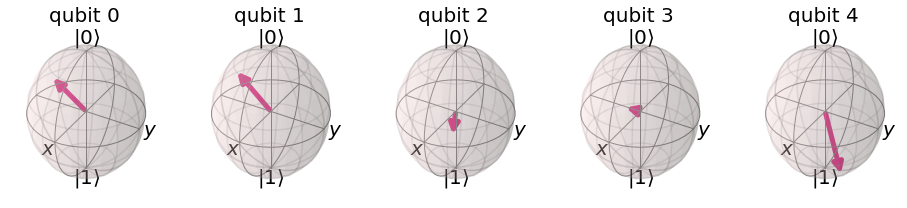

In [4]:
# generate 5 random qubit states and visualize bloch spheres
state = generate_qubit_state()
for _ in range(4):
    state = state.tensor(generate_qubit_state())
plot_bloch_multivector(state)

## Part 2
#### Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

In [202]:
def swap_test(state_1: Statevector, state_2: Statevector, backend=backend, shots=1024) -> float:
    """Swap test: if state_1 and state_2 are orthogonal Pr(q[0]=0) = 1/2, otherwise if q[1] and q[2] are equal Pr(q[0]=0) = 1
    
    Args:
        state_1, state_2: single qubit states to be compared
        
    Returns:
        Pr(q[0]=0)
    """
    assert state_1.num_qubits == 1 and state_2.num_qubits == 1
    
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    
    circuit.initialize(state_1.data, 1)
    circuit.initialize(state_2.data, 2)
    
    circuit.h(qreg_q[0])
    circuit.cswap(qreg_q[0], qreg_q[1], qreg_q[2])
    circuit.h(qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])
    
    results = execute(circuit, backend=backend, shots=shots).result()
    answer = results.get_counts()
    return answer['0'] / shots

In [203]:
random_state = generate_qubit_state()

In [204]:
swap_test(random_state, Statevector([1,0]))

0.5908203125

To reproduce a given qubit state using the 2 parameter variational circuit, I cast this as a minimization problem over rx_radians and rz_radians where to goal is to minimize the function to 0. At first I thought about running scalar optimization / binary search one variable at a time, but it may not always work since the optimal value for one parameter may not correspond to the optimal pair of parameters.

In [8]:
from scipy import optimize

In [9]:
def minimize_function_wrapper(params: np.ndarray, reference_state, shots=256):
    return 1 - swap_test(reference_state, generate_qubit_state(params[0], params[1]), shots=shots)

First, I try the methods in scikit.optimize.minimize. Powell seems to work the best from my limited testing, but still requires 100-200 function evaluations and doesn't always succeed. Using bounds with Powell method requires scipy >= 1.5

In [205]:
results = optimize.minimize(minimize_function_wrapper, (0, 0), args=(random_state, 256), 
                   method='Powell', bounds=((-pi, pi), (-pi, pi)), options={'disp': True, 'ftol': 1e-9})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 134


Next, I try differential evolution. This takes a lot of function evaluations (500+) but pretty much always succeeds with 100% accuracy. Setting maxiter=3 will bring down the function evaluations to about 150 and still retain reasonable accuracy.

In [208]:
results = optimize.differential_evolution(minimize_function_wrapper, args=(random_state, 256), bounds=((-pi, pi), (-pi, pi)))

In [209]:
results

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 423
     nit: 13
 success: True
       x: array([2.27009907, 1.75757538])

Lastly, I try minimizing the function using bayesian optimization, which has high (but not perfect accuracy) and only requires less than 50 function calls, but seems to require more shots per function evaluation to be accurate.

In [212]:
from skopt import gp_minimize

In [213]:
results = gp_minimize(lambda x: minimize_function_wrapper(x, random_state, 1024), ((-pi, pi), (-pi, pi)), n_calls=32)

In [214]:
reproduced_state = generate_qubit_state(results.x[0], results.x[1])

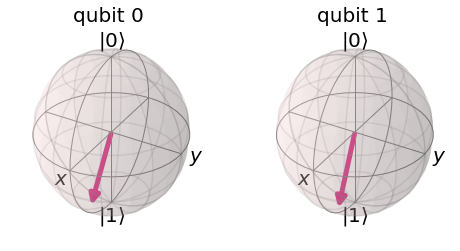

In [215]:
plot_bloch_multivector(random_state.tensor(reproduced_state))

In [216]:
swap_test(random_state, reproduced_state)

1.0

## Part 3
#### Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.

I am a bit confused why we can't simply measure the individual qubits if they are in |0> or |1> state. But lets attempt the question as given and first create a function that generates a random product state of n qubits in |0> or |1> state. If the state is in any product state, then we can use the previous routine in part 2 to determine the correct choice of parameters to reconstruct the state as well.

In [153]:
def generate_random_computational_product_state(num_qubits: int) -> Statevector:
    computational_basis = ([1, 0], [0, 1])
    state = Statevector(computational_basis[np.random.randint(0, 2)])
    for _ in range(num_qubits - 1):
        state = state.tensor(Statevector(computational_basis[np.random.randint(0, 2)]))
    return state

In [251]:
given_state = generate_random_computational_product_state(num_qubits=5)

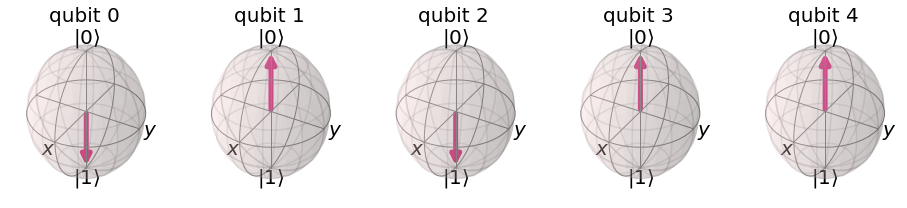

In [252]:
plot_bloch_multivector(given_state)

In [253]:
def reconstruct_computational_product_state(given_state: Statevector, shots=1024) -> Statevector:
    """Initialize given state of n qubits in product state of |0> and |1>s in quantum circuit, 
    and perform qubit by qubit swap test to reconstruct the state
    """
    qreg_q = QuantumRegister(given_state.num_qubits + 2, 'q')
    creg_c = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    # initialize first n qubits to the given state
    circuit.initialize(given_state.data, list(range(given_state.num_qubits)))
    
    measurement_qubit_index = given_state.num_qubits
    comparison_qubit_index = given_state.num_qubits + 1
    reconstructed_state: Statevector = None
    
    for i in range(given_state.num_qubits):
        # qubit by qubit swap test
        circuit.h(qreg_q[measurement_qubit_index])
        circuit.cswap(qreg_q[measurement_qubit_index], qreg_q[i], qreg_q[comparison_qubit_index])
        circuit.h(qreg_q[measurement_qubit_index])
        circuit.measure(qreg_q[measurement_qubit_index], creg_c[0])

        results = execute(circuit, backend=backend, shots=shots).result()
        answer = results.get_counts()
        
        if answer['0'] == shots: # if Pr(q[measurement_qubit]=0) = 1, q[i] and q[comparison_qubit] are equal
            if not reconstructed_state:
                reconstructed_state = Statevector([1, 0])
            else:
                reconstructed_state = Statevector([1, 0]).tensor(reconstructed_state)
                
        else: # qubit has to be in |1> state as given in the question
            if not reconstructed_state:
                reconstructed_state = Statevector([0, 1])
            else:
                reconstructed_state = Statevector([0, 1]).tensor(reconstructed_state)
        
        circuit.initialize([1, 0], measurement_qubit_index)
        circuit.initialize([1, 0], comparison_qubit_index)
    
    
    return reconstructed_state

In [254]:
reconstructed_state = reconstruct_computational_product_state(given_state, shots=1024)

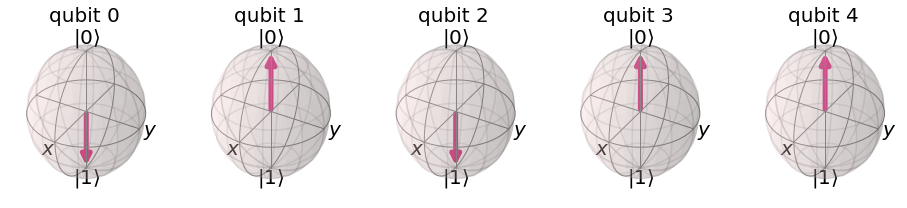

In [255]:
plot_bloch_multivector(reconstructed_state)